<hr>

# Image Undistortion

_How to make beautiful images even more beautiful._

<hr>
Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/Undistortion.ipynb?download&target=_blank).

<a class="anchor" id="toc"></a>


Kudos and thanks to [Joaquim Sanctorum](https://www.uantwerpen.be/en/staff/joaquim-sanctorum?target=_blank). Exchange with him preceded this blog entry, and his well-documented Matlab code served as a guideline for the remapping part below.



### Motivation

I recently started blogging my experiences with [image processing](../image_contrast), and have now been busy with a crucial part of image manipulation. 

When acquiring image data, one is often fascinated by the objects that were captured. At least me, in my case, because I have x-ray videos of locomoting piglets. 
However, looking closely, one will find that the almost every image is distorted, for various reasons. This can be prohibitive for scientific, quantitative data analysis.

Below, I present the tools that enable me to undistort images. 

Or imagine that you have a niggling relative (m/w) who might not wish to be barrel (or otherwise) distorted in family party photos. The following steps will help you to rectify their appearance and make them look perfect, as they desire.

- [take a grid photo](#grid_photo)
- [blob detection](#blob_detection)
- [idealize the grid](#grid_idealization)
- [interpolate](#interpolation)
- [remap](#remapping)

### Libraries

As most of the time, I will use `python`.

And again, multiple python libraries might be useful alternatives for the purpose below (for example, blob detection is available in pure numpy).

This time, I will focus on [opencv](https://opencv.org?target=_blank) and [scipy](https://docs.scipy.org/doc/scipy/reference?target=_blank).


In [1]:
import sys as SYS # system parameters (e.g. recursion limit)
import numpy as NP # numerical operations on data arrays
import pandas as PD # data frame handling (used herein to store data as csv)
import shelve as SH # storing the interpolator objects

import cv2 as CV # open computer vision, for image processing

import scipy.spatial.distance as DIST # distance measures
import scipy.interpolate as INTP # interpolation

import matplotlib.pyplot as MPP # plotting


# linear algebra helper
Normalize = lambda vec: vec / NP.linalg.norm(vec)

<hr>

<a class="anchor" id="grid_photo"></a> 
[&#9653;](#toc)

# Grid Photography 

To undistort, we need a physical reference of what a "straight" image would look like.
For our setup, we have a pair of square aluminium plates with holes drilled in it. The holes form a regular hexagonal (=triangular) grid. The number, diameter, and distance of the grid holes may vary. 
We use aluminium because it absorbs x-ray radiation; for light cameras, a paper with dots printed on it should be sufficient. 

To undistort, it is necessary to take a photo of these plates. Note that the plate is taped to the front of our image detector, in a way that it should be perfectly orthogonal to the view axis of the camera.

The raw test grid image below is available for [download here](user://notebooks/test_grid.tif?download&target=_blank).

In [2]:
img_raw = CV.imread("test_grid.jpg", CV.IMREAD_GRAYSCALE) 

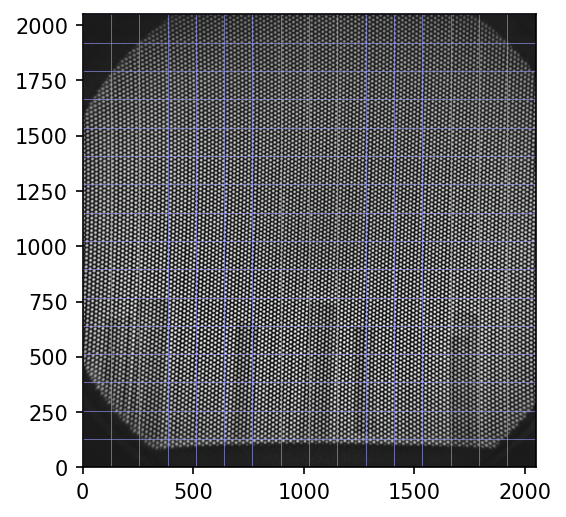

In [3]:
# prepare a figure
fig = MPP.figure(dpi = 150)
ax = fig.add_subplot(1,1,1,aspect = 'equal')

# plot the image
ax.imshow(img_raw, cmap = 'gray')

# add regular grid lines
for i in NP.linspace(0, img_raw.shape[0], 17, endpoint = True):
    ax.axhline(i, color = (0.6,0.6,1.0), lw = 0.5, ls = '-', alpha = 0.6)
    ax.axvline(i, color = (0.6,0.6,1.0), lw = 0.5, ls = '-', alpha = 0.6)
    
# display the plot
ax.set_xlim([0,img_raw.shape[0]])
ax.set_ylim([0,img_raw.shape[0]])
MPP.show();

As you see, the grid holes, through which the empty schene is revealed, are arranged on curved lines. Although the blue raster helps a bit, distortion can not always be seen by eye. I will visualize the complex curvature in detail below.


If it simplifies blob detection, the image should be value inverted.

In [4]:
# invert color
img = CV.bitwise_not(img_raw)

### Excourse: Fourier Patterns

Fun Fact: images can be transformed to the frequency domain. This can facilitate some computational operations, such as autocorrelation.

When attempting to automate the settings for blob detection, I experimented around with this. Ultimately, I did not not work it through. However, the results are useful (e.g. spatial autocorrelation) and beautiful (e.g. frequency space stars), for the reason that there is such a high, yet imperfect, regularity in the grid image.

I decided to retain these images, and hope you can appreciate them as well. 

In [5]:
# https://stackoverflow.com/questions/38476359/fft-on-image-with-python
def ImageFFT(img):
    
    # transform
    trafo = NP.fft.fft2(img)
    
    # shift
    fshift = NP.fft.fftshift( \
                     NP.multiply( trafo, NP.conj(trafo) ) \
             )
    
    # normalize
    return NP.abs(fshift) / NP.multiply(*img.shape)


# taken from https://www.mathworks.com/matlabcentral/fileexchange/37624-2d-autocorrelation-function
def ImageAutocorrelation(img):
    
    # transform    
    trafo = NP.fft.fft2(img)
    
    # inverse transform and shift
    fshift = NP.fft.fftshift( \
                 NP.fft.ifft2(\
                     NP.multiply( trafo, NP.conj(trafo) )   \
                 ) \
             )
    
    # normalize
    return NP.abs(fshift)/NP.multiply(*img.shape)

In [6]:
autocorr = ImageAutocorrelation(img)
fft = ImageFFT(img)


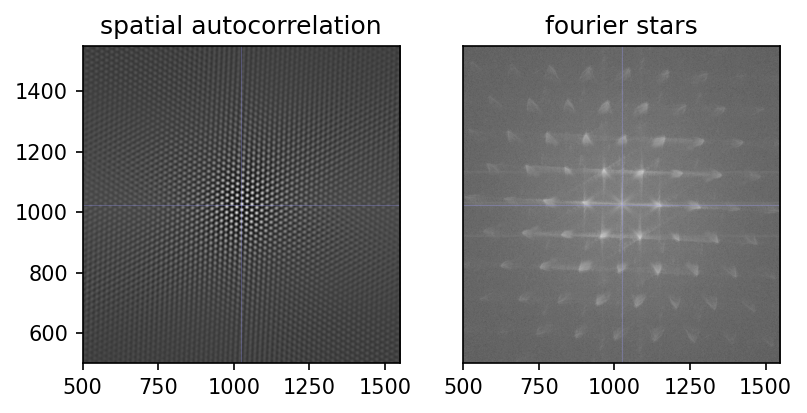

In [7]:
fig = MPP.figure(dpi = 150)

ax = fig.add_subplot(1,2,1,aspect = 'equal')
ax.set_title('spatial autocorrelation')
ax.imshow(autocorr, cmap = 'gray')
ax.axvline(1024, color = (0.6,0.6,1.0), ls = '-', lw = 0.5, alpha = 0.3)
ax.axhline(1024, color = (0.6,0.6,1.0), ls = '-', lw = 0.5, alpha = 0.3)

ax = fig.add_subplot(1,2,2,aspect = 'equal', sharex = ax, sharey = ax) 
ax.set_title('fourier stars')
ax.imshow(NP.log10(fft), cmap = 'gray') # 
ax.axvline(1024, color = (0.6,0.6,1.0), ls = '-', lw = 0.5, alpha = 0.3)
ax.axhline(1024, color = (0.6,0.6,1.0), ls = '-', lw = 0.5, alpha = 0.3)
ax.get_yaxis().set_visible(False)

ax.set_xlim([500, 1548])
ax.set_ylim([500, 1548])
MPP.show()

<hr>

<a class="anchor" id="blob_detection"></a> 
[&#9653;](#toc)

# Blob Detection

Blob detection is a charming idea: take an image, and let the computer find all relevant objects in it. The pitfall is in "relevant". Of course, relevance criteria need to be specified.

Luckily, `opencv` has quite convenient functionality for this, which you can study [in this tutorial](https://www.learnopencv.com/blob-detection-using-opencv-python-c?target=_blank).

Here is how I initialize the detector for our test image.

In [8]:
# Setup SimpleBlobDetector parameters.
params = CV.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
# params.maxThreshold = 800

# Filter by Area.
params.filterByArea = True
params.minArea = 10

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.8

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.01

# Create a detector with the parameters
detector = CV.SimpleBlobDetector_create(params)


We will call the blobs "keypoints" to sound more elaborate. Let's find them!

In [9]:

# Detect blobs.
print ('detecting', end = '')
keypoints = detector.detect(img)
print ('... done')

print (len(keypoints), 'keypoints found.')

kp = keypoints[0]
# print (kp)
# print (dir(kp))
print ('keypoints have a position and size:', kp.pt, kp.size)


detecting... done
11898 keypoints found.
keypoints have a position and size: (571.5708618164062, 968.609375) 11.401754379272461


In [10]:
# we will store sizes and positions in arrays.
keypoint_positions = [kp.pt for kp in keypoints]
keypoint_sizes = [kp.size for kp in keypoints]

And, to briefly inspect what we found:

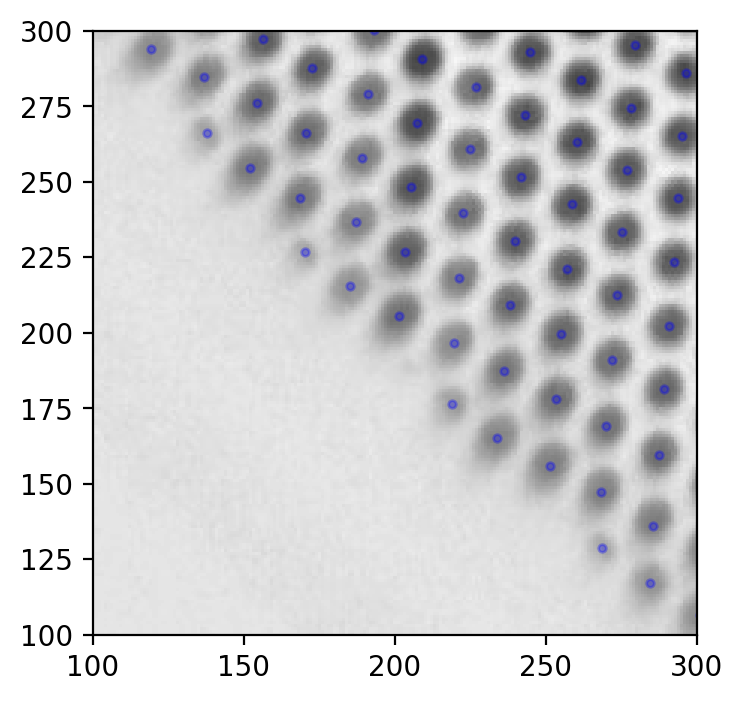

In [11]:
fig = MPP.figure(dpi = 200)
ax = fig.add_subplot(1,1,1,aspect = 'equal')
ax.imshow(img, cmap = 'gray')
keypoint_posmat = NP.stack(keypoint_positions, axis = 0)
ax.scatter(keypoint_posmat[:, 0], keypoint_posmat[:,1], s = 30, marker = '.', color = 'b', alpha = 0.3)
ax.set_xlim([100,300])
ax.set_ylim([100,300])
MPP.show()


Seems good. Something like this should be what you strive for when detecting grid holes.

### Filter Margin Points

On regular grids as ours, blob detection usually works well in the central part. The margin of the field of view is where it tends to fail occasionally. 

Hence, a good strategy might be to remove one row of blobs on the margin. Marginal blobs have fewer neighbors, because there are no neighbors beyond the margin. To detect them, we need to count how many immediate neighbors each blob has.

That in turn requires the distance between each pair of keypoints. This might be computationally intense, so hold your seat.

In [12]:
print ("calculating cross distances... ", end = '')
cross_distances = DIST.squareform(DIST.pdist(keypoint_positions))
print ("done!")

calculating cross distances... done!


Per definition, neighbors are close. Let's quantify how close they are in our case.

In [13]:
# exclude the diagonal, i.e. distance of a keypoint to itself.
cross_distances_nodiag = cross_distances.copy()
cross_distances_nodiag[NP.eye(cross_distances.shape[0], dtype = bool)] = NP.NAN

# the median of the closest neighbors should be a good estimate.
closest_neighbor = NP.median(NP.nanmin(cross_distances_nodiag, axis = 1))

# ... but we rather add a safety margin.
neighborhood_radius = closest_neighbor * 1.3 # radius of circle that usually encloses exactly six neighbours

Now, count the neighbors within that radius.

In [14]:
# again, exclude the blob itself.
neighbors = NP.logical_xor(cross_distances < neighborhood_radius, NP.eye(cross_distances.shape[0]))

# count
n_neighbors = NP.sum(neighbors, axis = 0)


Now that we know how many neighbors each keypoint has, we can filter out the marginal ones.

In [15]:

# filter for those keypoints with a minimum number of neighbors
keypoints = [keypoints[i] for i in range(len(keypoints)) if n_neighbors[i] >= 4]

image_points = NP.stack([kp.pt for kp in keypoints], axis = 0).copy() # used below
image_points[:5, :]

array([[571.57086182, 968.609375  ],
       [402.19329834, 932.1652832 ],
       [332.27703857, 893.13446045],
       [551.58642578, 885.02850342],
       [516.16876221, 866.13568115]])

This is just one method of post hoc filtering. There are more. One could even exclude or include keypoints manually.

<hr>

<a class="anchor" id="grid_idealization"></a> 
[&#9653;](#toc)

# Grid Idealization

The next step is to determine where the regular key points *should* be. Luckily, the ads of the manufacturer of the alu plate tell us they are in a perfect triangular grid, which can also be interpreted as a hexagonal grid with center points.

Our ideal grid should not be infinitely large. Instead, it has to have precisely as many holes as the original plate photo revealed, and be in approximately the same orientation. 


To idealize the grid, let's first update our information about the remaining keypoints.

In [16]:
### update keypoint data
keypoint_sizes = [kp.size for kp in keypoints]
keypoint_positions = [kp.pt for kp in keypoints]

cross_distances = DIST.squareform(DIST.pdist(keypoint_positions))
neighbors = NP.logical_xor(cross_distances < neighborhood_radius, NP.eye(cross_distances.shape[0]))
n_neighbors = NP.sum(neighbors, axis = 0)


### get positions into an array
keypoint_positions = NP.stack(keypoint_positions, axis = 0).copy()

# center the array
center_idx = NP.argmin(NP.sum(NP.abs(keypoint_positions - NP.mean(keypoint_positions, axis = 0)), axis = 1))
center_shift = keypoint_positions[center_idx, :]
keypoint_positions -= center_shift


### Object Points
Once more, I found it intuitive to implement the solution to a problem via object oriented programming.

I quickly define a "point" class, which holds a keypoint, functions to apply on it, and references to neighbors.

In [17]:

### Properties of the hexagonal grid
# cf. https://hexnet.org/content/hexagonal-geometry#geometry
dx = NP.sqrt(3.)/2.
dy = 1.

### approximate directions of neighboring points
# works here because the grid hung almost straight on the photo,
# otherwise rotate the photo prior to this step.
directions = [NP.array(dirn) for dirn in [(0, +dy), (+dx, +dy/2.), (+dx, -dy/2.), (0, -dy), (-dx, -dy/2.), (-dx, +dy/2.)]]


### neighbor lookup
def GetNeighbors(idx):
    return NP.flatnonzero( neighbors[idx, :] )

### the point class
class Point(object):
    # a keypoint in an idealized grid
    
    def __init__(self, idx):
        # constructor
        self.idx = idx # the index of this one in our keypoint list
        self.coords = None # coordinate position in idealized space, to be filled later
        self.is_mapped = False # flag mapped keypoints
        self.neighbors = GetNeighbors(idx) # link neighbor ids
        self.position = keypoint_positions[idx, :] # position in raw image

    def SetMap(self, coords):
        # when true position is found, store it
        self.coords = coords
        self.is_mapped = True if coords is not None else False

    def GetPoint(self):
        # return the inaccurate photo position
        return keypoints[self.idx]

    def GetVector(self, target_point):
        # vector from self to target_point
        return target_point.position - self.position

    def PropagateGridPosition(self, target_point):
        # propagate the ideal position to a neighbor point
        offset = directions[NP.argmax([dirn.dot(self.GetVector(target_point)) for dirn in directions])]
        target_point.SetMap(self.coords + offset)


Because the hexagon was not exactly aligned, a slight initial rotation might be a good heuristic.

In [18]:

## rotate positions to roughly align hexagons
# i.e. make the north neighbor point northwards.

# take the center
center = Point(center_idx)

# ... and the northward neighbor
north_neighbor = center.neighbors[NP.argmax([directions[0].dot(keypoint_positions[neigh, :]) for neigh in center.neighbors])]

# normalized direction vector, so that it is the basis "y" of the new coordinate system
new_y = Normalize(keypoint_positions[north_neighbor, :] - center.position).ravel()

# we'll use the cross product twice to construct an orthogonal basis "x"
helper_y = NP.append(new_y, 0.) # (but therefore we briefly expand to 3D)
new_x = Normalize( NP.cross(helper_y, NP.cross(NP.array([1., 0., 0.]), helper_y)) )[:2]

# combine the new basis
new_basis = NP.stack([new_x, new_y], axis = 1)
# print (new_x, new_y)

# transform, i.e. rotate the compass
print ('before rotation:', keypoint_positions[north_neighbor, :])
keypoint_positions = keypoint_positions.dot(new_basis)
print ('after rotation:', keypoint_positions[north_neighbor, :])


before rotation: [ 0.80517578 18.35229492]
after rotation: [-1.11022302e-16  1.83699493e+01]


### Recursively Map Neighbors

Next, the procedure of neighbor position propagation has to be applied to the whole grid.
I've chosen to do this recursively. Recursion is a programming concept that involves a function calling itself for a finite number of times. This concept might seem odd if you encounter it for the first time, but code can be quite elegant. 

We need somewhere to start the recursive cascade - this can be any point, so let's arbitrarily choose the one closest to the center of the image.

In [19]:

## convert all points to "point" objects
# but their position is yet unknown
all_pointmaps = [Point(idx) for idx in range(len(keypoints))]

# find the center point (was found above)
centerpoint = all_pointmaps[center_idx]

# define center position to be (0,0), or anything you like. 
centerpoint.SetMap([0, 0])

# print (centerpoint)
# print (centerpoint.coords, centerpoint.neighbours)


## recursive neighbor mapping
def DirectNeighbourRecursion(focus_point):
    # this function iterates over the neighbors of a point and adjust their real position, 
    # based on the position of the focus point calling them.
    
    # iterate all neighbors of the focus point
    for neighbor_idx in focus_point.neighbors:
        
        # take the neighbor
        neighbor = all_pointmaps[neighbor_idx]
        
        # only map previously unmapped neighbors
        if not neighbor.is_mapped:
            # give it a position
            focus_point.PropagateGridPosition(neighbor)
            
            # descent one recursion step to assign the neighbors of the neighbors.
            DirectNeighbourRecursion(neighbor)



When running this particular recursion, I encountered an error claiming the recursion limit had been reached. That limit is set by python per default as a safety measure to avoid memory overflow. A recursion limit of 1000 means that recursion will stop after 1000 nested self-calls of the function. 

My test grid has too many points. Luckily, the recursive function is not computationally intense. So I dared, for the first time in my programming lifetime, to increase that recursion limit. Exciting!

If you read these lines, that means my computer did not explode. 

In [20]:
# !!! crazy recursion
# print(SYS.getrecursionlimit())
SYS.setrecursionlimit(10000)

# ... and fire!
DirectNeighbourRecursion(centerpoint)

Wow. All points got mapped. Unexpectedly quick, actually - although recursions can run out of hand quickly.

In theory, many recursions can be replaced by loops. There are even proper theorems proving that every tail recursion can. However, for the function above, I could not immediately think of a loop alternative which avoids traversing all key points more than once. So better get used to recursion, it's useful!

Let's store the coordinate data we have obtained, which are 
- "object points", i.e. the true positions of key points in an idealized hex grid
- "image points", i.e. the raw pixel position on the image

In [21]:
# (i) object points: the idealized position in our 2D world
object_points = NP.stack([pnt.coords for pnt in all_pointmaps], axis = 0)

# a quick check that no position is assigned twice. 
# If this assertion fails, go back to start and refine blob detection 
#  (watch out for keypoints with more than seven neighbors)
assert object_points.shape[0] == PD.DataFrame(object_points, columns = ['x', 'y']).drop_duplicates(inplace = False).shape[0]

# (ii) image points, as found by blob detection
image_points[:5, :]


array([[571.57086182, 968.609375  ],
       [402.19329834, 932.1652832 ],
       [332.27703857, 893.13446045],
       [551.58642578, 885.02850342],
       [516.16876221, 866.13568115]])

### Procrustes Superimposition

Procrustes superimposition is the removal of differences in rotation/scaling/translation of points. I've added this to my repertoire [during work for my masters thesis](https://doi.org/10.1007/s11692-018-9456-9?target=_blank). Here is a minimal python implementation, in this case removing the affine difference between image points and object points.

In [22]:
# some basic helper functions that will be useful
GetCentroid = lambda data: NP.mean(data, axis = 0)
Centered = lambda data: data-NP.mean(data, axis = 0)
GetRCS = lambda data: NP.sqrt(NP.sum(NP.power(Centered(data), 2)))
GetNormed = lambda data: Centered(data) / GetRCS(data)


In [23]:
# the optimal rotation matrix can be found by this intuitive singular value decomposition
A = NP.dot(GetNormed(image_points.copy()).T, GetNormed(object_points.copy()))
U,singular_values,V = NP.linalg.svd(A, full_matrices=False)
rotation_matrix = NP.dot(V.T, U.T)

print (singular_values, '\n', rotation_matrix)

[0.52541465 0.47447144] 
 [[ 0.99946426 -0.03272909]
 [ 0.03272909  0.99946426]]


In [24]:
# here, three steps happen at once: the (normalized) object points are scaled, rotated and moved 
# to match the image points as closely as possible.
transformed_object_points = \
      GetRCS(image_points.copy()) \
        * singular_values.sum() \
        * NP.dot(GetNormed(object_points.copy()), rotation_matrix) \
      + GetCentroid(image_points.copy())

transformed_object_points[:5]

array([[557.32974166, 959.48463229],
       [392.14821227, 926.99245381],
       [325.33171385, 891.27915157],
       [538.14599484, 874.83487059],
       [504.73774563, 856.97821947]])

In abscence of better knowledge, the Procrustes step brings the object points as close to the image points as possible, so that they are aligned in a mathematically optimal way.

### Inspecting the result

To briefly inspect the result, I'm changing terminology again. Our image points are in fact the distorted grid, whereas our transformed object points are the undistorted (real) grid. Maybe you find these new terms confusing, but maybe you find them revealing. You can change it in your own blog posts if you like.

In [25]:
distorted_grid = image_points.copy()
undistorted_grid = transformed_object_points


These two grids, with corresponding points in the respective rows, are the core result of our procedure. Once we have obtained them, they should be stored, because - as you will see below - these points connect the ugly world of undistorted images with the beautiful world of scientific imagery.

In [26]:
## results can be stored to disk
PD.DataFrame(distorted_grid, columns = ['x','y']).to_csv('testgridpoints_distorted.csv', sep = ';')
PD.DataFrame(undistorted_grid, columns = ['x','y']).to_csv('testgridpoints_undistorted.csv', sep = ';')

And, as every beautiful set of results, the points should be plotted.

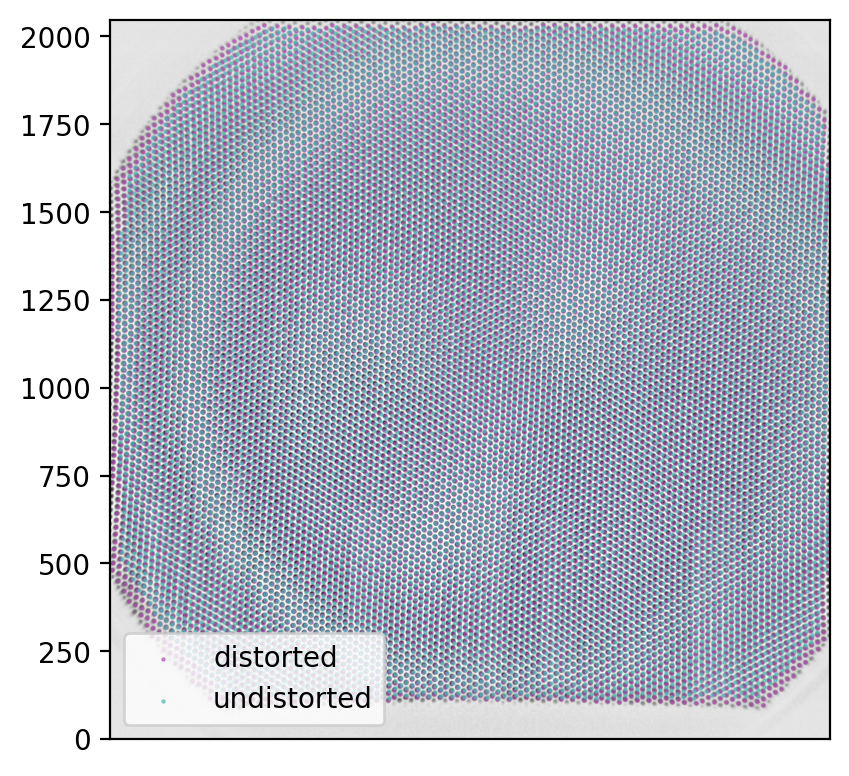

In [27]:
# plot the results for comparison
fig = MPP.figure(dpi = 200)
ax = fig.add_subplot(1,1,1,aspect = 'equal')

# raw image
ax.imshow(img, cmap = 'gray')

# distorted grid
ax.scatter(distorted_grid[:, 0], distorted_grid[:, 1] \
           , s = 5, marker = '.', color = (0.7, 0.3, 0.7), lw = 0.5, alpha = 0.6 \
          , label = 'distorted')

# result of undistortion
ax.scatter(undistorted_grid[:, 0], undistorted_grid[:, 1] \
           , s = 5, marker = '.', color = (0.3, 0.7, 0.7), lw = 0.5, alpha = 0.6 \
          , label = 'undistorted')

ax.get_xaxis().set_visible(False)
MPP.tight_layout()
ax.legend()
# fig.savefig('undistortion_offset.png', dpi = 300, transparent = False) # save it to be able to zoom in and out
ax.set_xlim([0,img.shape[0]])
ax.set_ylim([0,img.shape[1]])
MPP.show()

There appears to be an interesting circular area on which the image points are actually accurate as they are. 

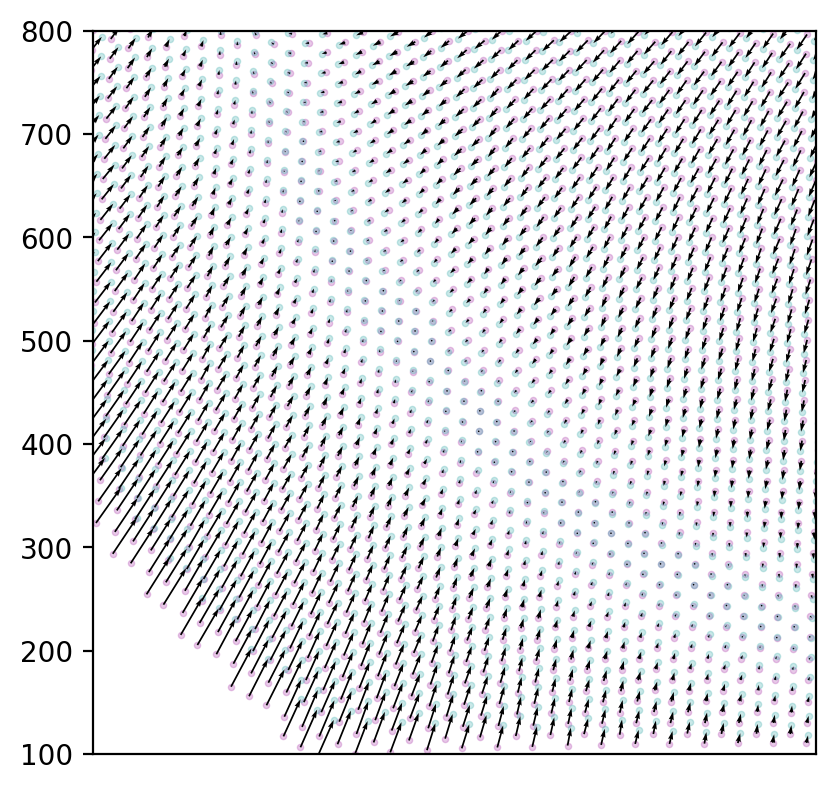

In [28]:
arrows = NP.subtract(undistorted_grid, distorted_grid)

fig = MPP.figure(dpi = 200)
ax = fig.add_subplot(1,1,1,aspect = 'equal')

# distorted grid
ax.scatter(distorted_grid[:, 0], distorted_grid[:, 1] \
           , s = 5, marker = 'o', color = (0.7, 0.3, 0.7), lw = 0.5, alpha = 0.3 \
          , label = 'distorted')

# result of undistortion
ax.scatter(undistorted_grid[:, 0], undistorted_grid[:, 1] \
           , s = 5, marker = 'o', color = (0.3, 0.7, 0.7), lw = 0.5, alpha = 0.3 \
          , label = 'undistorted')


ax.quiver(distorted_grid[:, 0], distorted_grid[:, 1] \
          , arrows[:, 0], arrows[:, 1] \
          , units = 'xy' \
          , scale = 1.0, scale_units = 'xy' \
          )

ax.get_xaxis().set_visible(False)
MPP.tight_layout()
# fig.savefig('undistortion_offset.png', dpi = 300, transparent = False) # save it to be able to zoom in and out
ax.set_xlim([100,800])
ax.set_ylim([100,800])
MPP.show()

Again, beautiful images. But what can we do with it?

<hr>

<a class="anchor" id="interpolation"></a> 
[&#9653;](#toc)

# Interpolation

One straight-forward, but critical step is the mapping of the undistorted (object point) space and the distorted (image) space. 

By mapping I mean that we want to be able to choose an arbitrary point in either space and find the corresponding position in the other. 
The transformation from the distorted to the undistorted image space is called "undistortion"; it is what typical image processing tools attempt. 
There are also tools for distortion, but fussy relatives wouldn't approve the images these tools produce. The procedure of distortion involves warping the true image in a weird way so that straight lines usually become curved. 

We have already found and plotted a mapping of the corresponding points above. 
However, the exact position is only known at the grid hole centres. Everything in between has to be interpolated. 

Computationally, we need to fit an interpolator object to perform the desired transformations.


As a reference, I often try to reproduce what XMALab does. 
Consulting the [original publication (Knörlein et al., 2016)](https://doi.org/10.1242/jeb.145383?target=_blank) points towards a procedure called local weighted mean (LWM) transformation ([Goshtasby, 1988](https://doi.org/10.1016/0262-8856(88)90016-9?target=_blank )). 
I have not studied this in detail, but suspect that this is just a different term for linear interpolation.

LWM is available in `matlab`. Instead of ranting about matlab now, I'll just give you the code.

```
%% matlab code for image undistortion
image_points = readtable('image_points.csv', 'Delimiter', ';');
object_points = readtable('object_points.csv', 'Delimiter', ';');

% https://www.mathworks.com/help/images/ref/fitgeotrans.html
tform = fitgeotrans(table2array(image_points), table2array(object_points), 'lwm', 18);


I = imread('test_grid.jpg');

J = imwarp(I,tform,'OutputView',imref2d(size(I)));
```

But why go to `matlab` if there is [`python`](https://zen-of-python.info?target=_blank)?

Scipy offers several interpolators [in its interpolation submodule](https://docs.scipy.org/doc/scipy/reference/interpolate.html?target=_blank). 
Here are some that I tested, with code to initialize them. Documentation is [available here](https://docs.scipy.org/doc/scipy/reference/interpolate.html?target=_blank).

*UPDATE 2020/04/23 [FM]: initial technical problems solved, all interpolators should work.*


#### Rbf
A very powerful and reliable interpolator is RBF ([radial basis function interpolation](https://en.wikipedia.org/wiki/Radial_basis_function_interpolation?target=_blank), [`scipy.interpolate.Rbf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html?target=_blank)). It has served me well in the past. 
It can handle multi-dimensional data, and there are several useful options for interpolation functions (`multiquadric, gaussian, quintic, cubic, linear, thin_plate`). 
Computation-wise, RBF is intense, so I test with a different interpolator, and only roll out RBF when everything works. 

The implementation for our problem is shown below.




#### CloughTocher2DInterpolator
Another algorithm is `scipy.interpolate.CloughTocher2DInterpolator`, but I admit having trouble with pronounciation (try saying it out loud!). I selected it because the documentation states that it is piecewise cubic (i.e. more dof than linear), smooth (i.e. no kinks or discontinuities), and curvature minimizing. Though not a technical expert, I can imagine those are reasonable assumptions for actual image distortion. 

Clough-Tocher executes flawlessly and even in reasonable time.
I use it below for quick interpolation.




#### LinearNDInterpolator
The simplest working one I found, `scipy.interpolate.LinearNDInterpolator`, guess what, linearly interpolates an N-dimensional output, meaning that we do not have to fit `x` and `y` separately. 

```
Undistortion_x = INTP.LinearNDInterpolator( \
                                          x = undistorted_grid[:,0] \
                                        , y = undistorted_grid[:,1] \
                                        , z = distorted_grid[:,0] \
                                        ) 
```




#### interp2d
My usual second choice is `scipy.interpolate.interp2d` (the analogon to matlab `interp2` which you would use if you were using matlab, but who would), fails because it finds my epsilon too small. Here is what I tried:
```
Undistortion_x = INTP.interp2d( \
                   distorted_grid[:, 0] \
                 , distorted_grid[:, 1] \
                 , undistorted_grid[:, 0] \
                 , kind = 'linear' \
                 )
```




#### SmoothBivariateSpline
The quickest working alternative is `scipy.interpolate.SmoothBivariateSpline`. I used it when trying to test out the mesh remapping below, to speed the process. This one also needs to fit `x` and `y` separately.

```
Undistortion_x = INTP.SmoothBivariateSpline( \
                      x = undistorted_grid[:,0] \
                    , y = undistorted_grid[:,1] \
                    , z = distorted_grid[:,0] \
                    )
```

### Implementation

In [29]:
## interpolator choice
# if you choose quick interpolation, the second set of functions are preferred.
quick_interpolate = True

rbf_function = 'linear' # [multiquadric, gaussian, quintic, cubic, linear, thin_plate]

In [30]:
if not quick_interpolate:

    Undistortion = INTP.Rbf( \
                       distorted_grid[:, 0] \
                     , distorted_grid[:, 1] \
                     , undistorted_grid \
                     , function = rbf_function \
                     , mode = 'N-D' \
                     )




In [31]:
if not quick_interpolate:
    Distortion = INTP.Rbf( \
                       undistorted_grid[:, 0] \
                     , undistorted_grid[:, 1] \
                     , distorted_grid \
                     , function = rbf_function \
                     , mode = 'N-D' \
                     )

The quick alternative, for testing:

In [32]:

## a gem from the scipy documentation: 
# The interpolant is constructed by triangulating the input data with Qhull, and constructing 
# a piecewise cubic interpolating Bezier polynomial on each triangle, 
# using a Clough-Tocher scheme. The interpolant is guaranteed to be continuously differentiable. 
# The gradients of the interpolant are chosen so that the curvature of the interpolating surface 
# is approximatively minimized.
# [BINGO! That was exactly what I was looking for.]

if quick_interpolate:
    Undistortion = INTP.CloughTocher2DInterpolator(points = distorted_grid, values = undistorted_grid)
    Distortion = INTP.CloughTocher2DInterpolator(points = undistorted_grid, values = distorted_grid)


These interpolators can be used to undistort any set of points from the image. Or, conversely, to distort theoretical points from the reconstructed ideal world back to twisted real life.

### Storing the result

Though the mapped points above in principle hold all the information necessary to de-serialize interpolation, it might be a good strategy to store a good interpolator after a long fitting procedure. 
For RBF, this is a bit complicated, but can be solved (as explained [here](https://stackoverflow.com/questions/23997431/is-there-a-way-to-pickle-a-scipy-interpolate-rbf-object?target=_blank)).

In [33]:

interpolators = {'distortion': Distortion, 'undistortion': Undistortion}

with SH.open('testgrid_%s.pck' % ('CT' if quick_interpolate else 'RBF_%s' % (rbf_function))) as db:
    for intp_label, intp_function in interpolators.items(): 
        for key in intp_function.__dict__.keys():
            if key != '_function' and key!= 'norm':
                db["%s_%s" % (intp_label, key)] = intp_function.__getattribute__(key) 

    db.sync()

Loading happens as follows:

In [34]:

### initialize empty interpolators
if quick_interpolate:
    # (i) for Clough-Tocher
    Distortion = INTP.CloughTocher2DInterpolator( \
                           points = NP.array([[1,0,3], [3,8,5]]).T \
                         , values = NP.array([[1,2,3], [3,4,5]]).T \
                        )
    
    Undistortion = INTP.CloughTocher2DInterpolator( \
                           points = NP.array([[1,0,3], [3,8,5]]).T \
                         , values = NP.array([[1,2,3], [3,4,5]]).T \
                        )
    
    
else:
    # (ii) for RBF
    Distortion = INTP.Rbf(  NP.array([1.,2,3]) \
                          , NP.array([10.,20,30]) \
                          , NP.array([[1,2,3], [3,4,5]]).T \
                          , function = rbf_function
                         , mode = 'N-D' \
                         )
    
    Undistortion = INTP.Rbf(  NP.array([1,2,3]) \
                          , NP.array([10,20,30]) \
                          , NP.array([[1,2,3], [3,4,5]]).T \
                          , function = rbf_function
                         , mode = 'N-D' \
                         )

    
### load the data
interpolators = {'distortion': Distortion, 'undistortion': Undistortion}

# fill them with data from before
with SH.open('testgrid_%s.pck' % ('CT' if quick_interpolate else 'RBF_%s' % (rbf_function))) as db:

    for key, value in db.items():
        for intp_label, intp_function in interpolators.items():
            if intp_label in key:
                intp_function.__setattr__(key.replace('%s_' % (intp_label), ''), value)


<hr>

<a class="anchor" id="remapping"></a> 
[&#9653;](#toc)

# Remapping

For example, such a set of points could be pixels. Let's be daring - how about taking ALL PIXEL POSITIONS? Not a humble task, sure, but we can do it.

Mapping all pixel positions allows to **remap** (i.e. resample) the distorted image and thereby undistort it. 
My colleague Joaquim introduced this to me as a huge lookup table: for every pixel in the image, go to the lookup table and find out where it really was.

The only problem: there are $2048^{2} = 2^{22} = 4194304$ pixels in our images. Multiply this by thousands of frames in my videos. But only multiply it for fun: luckily, the same lookup table applies to all images.


`opencv` is well optimized for remapping procedures. So we just need the lookup table, for `x` and `y` separately.

In [35]:
# https://docs.opencv.org/4.3.0/d1/da0/tutorial_remap.html

map_x = NP.ones(img.shape) * NP.arange(img.shape[0])
map_y = NP.ones(img.shape) * NP.arange(img.shape[0]).T

# these maps would just reproduce the original image.

In [36]:
print ('constructing maps for remapping')

# loop x and y indices
for idx in range(map_x.shape[0]):
    for idy in range(map_x.shape[1]):
        
        # regularly print progress
        if (idx % 5 == 0) and (idy == 0):
            print ('%04.0f / %i' % (idx, map_x.shape[0]), end = '\r', flush = True)
        
        # because we look up undistorted pixels in the distorted image,
        # we need to use the "Distortion" function here.
        lookup = Distortion(NP.array([idx]), NP.array([idy]))[0]
        map_x[idx, idy] = lookup[0]
        map_y[idx, idy] = lookup[1]
    

print ('%04.0f / %i ... done!' % (map_x.shape[0], map_x.shape[0]))

# float data type is required for opencv remapping
map_x = NP.array(map_x, dtype=NP.float32).T
map_y = NP.array(map_y, dtype=NP.float32).T

constructing maps for remapping
2048 / 2048 ... done!


Note: it might be useful to store the maps in a `shelve` for quick access later.


I elaborated on interpolators above. Here comes another one: `opencv.remap` requires you to choose. 
However, the choice here is less crucial, because our distance to the nearest true point is maximum half a pixel, due to the fine-grained map. In other words: if our interpolator above was poorly set up, this second one does not make it much worse.

I chose [Lanczos resampling](https://en.wikipedia.org/wiki/Lanczos_resampling?target=_blank) here, but if you dislike uncommon names or sinc functions, you should be fine with `CV.INTER_CUBIC`, or if you still find that *crazy sh't*, take `CV.INTER_LINEAR`.

In [37]:
# remapping with opencv
img_undistorted = CV.remap(img, map_x, map_y, CV.INTER_LANCZOS4) 

That was quick!

Our image was just undistorted. Map construction took a minute, remapping with interpolation was done in milliseconds. There is hope for my distorted videos!

Let's have a look:

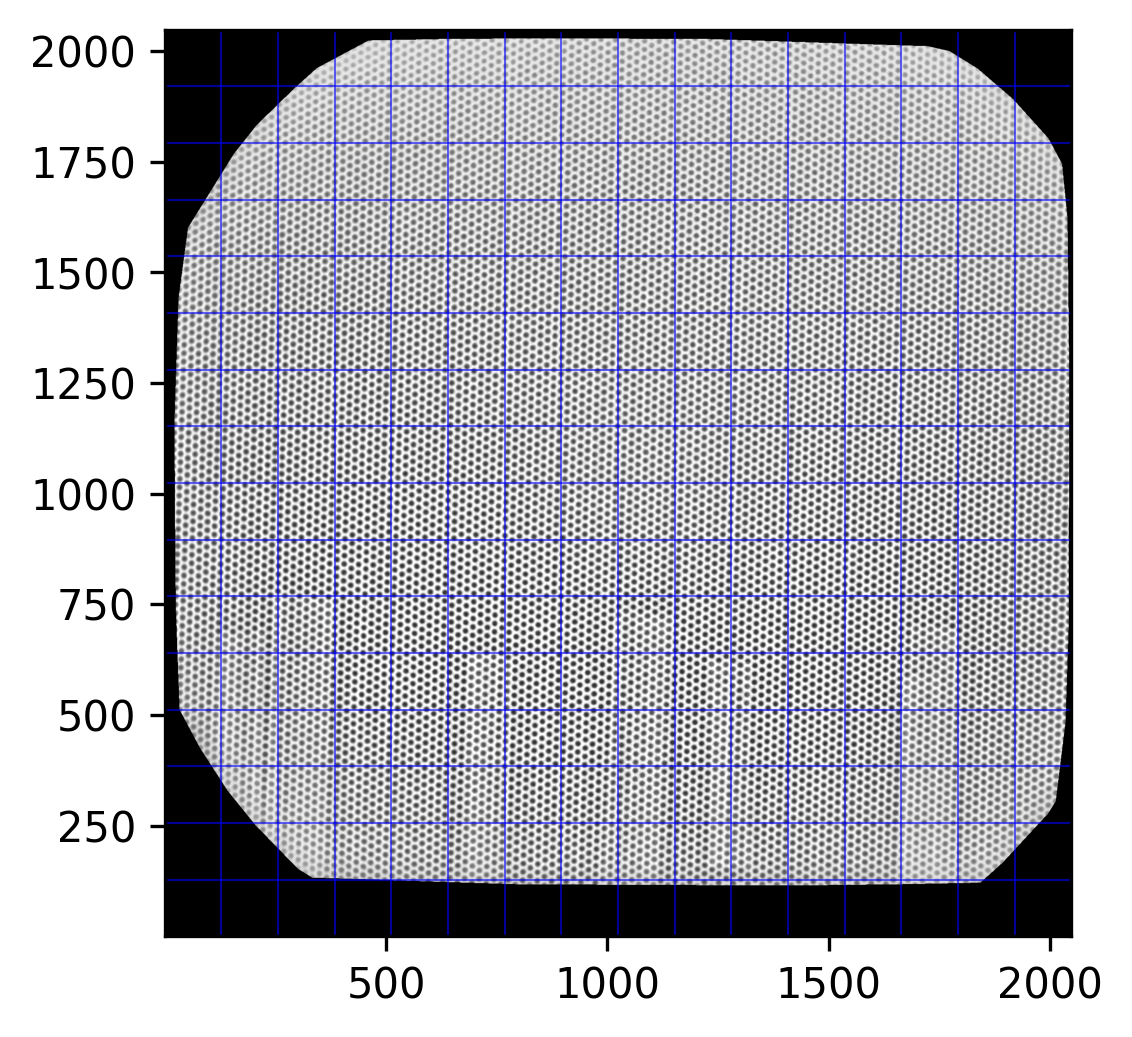

In [38]:
fig = MPP.figure(dpi = 300)

ax = fig.add_subplot(1,1,1,aspect = 'equal')
ax.imshow(img_undistorted, cmap = 'gray')
for i in NP.linspace(0,img_undistorted.shape[0],17, endpoint = True):
    ax.axhline(i, color = 'b', lw = 0.5, ls = '-', alpha = 0.6)
    ax.axvline(i, color = 'b', lw = 0.5, ls = '-', alpha = 0.6)

ax.set_xlim([1,2048])
ax.set_ylim([1,2048])
MPP.show();

A bit tilted, but homogeneously. Fairly nice beads on lines. 

Note how the Clough-Tocher magic above only applies to points within the convex hull of the keypoints we found. Everything outside is blanked. But with the fine grid going close to the margin, there is no need to enter the unsafe realm of extrapolation.



# Concluding Remarks

Let's compare distorted and undistorted point spaces once more:

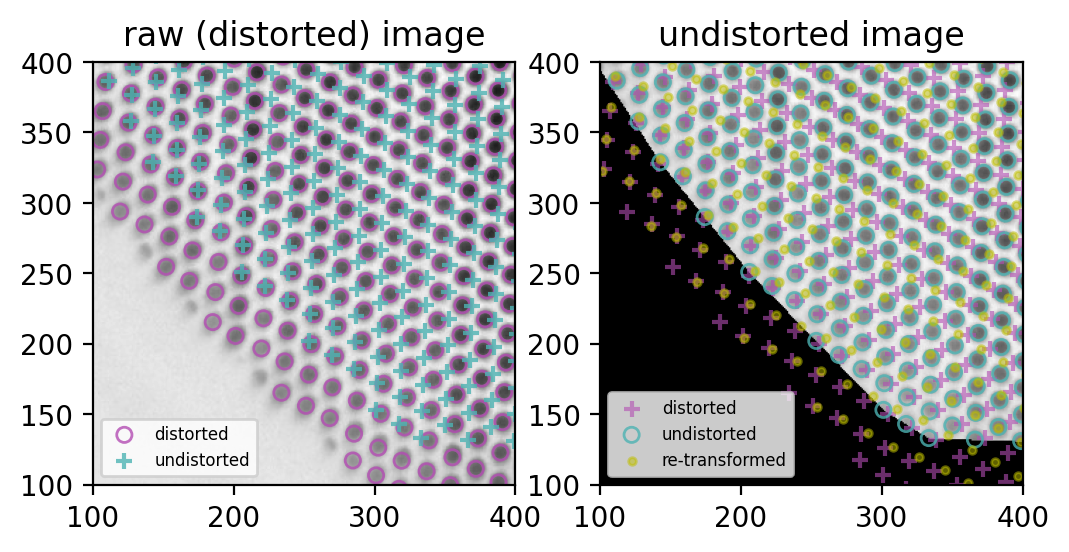

In [40]:

test_redistort = Distortion(distorted_grid[:, 0], distorted_grid[:, 1])


fig = MPP.figure(dpi = 200)
ax = fig.add_subplot(1,2,1,aspect = 'equal')
ax.set_title('raw (distorted) image')
ax.imshow(img, cmap = 'gray')
ax.scatter(distorted_grid[:, 0], distorted_grid[:,1], s = 30 \
           , marker = 'o', edgecolor = (0.7, 0.3, 0.7), facecolor = 'none', alpha = 0.8 \
          , label = 'distorted')
ax.scatter(undistorted_grid[:, 0], undistorted_grid[:,1], s = 30 \
           , marker = '+', color = (0.3, 0.7, 0.7), alpha = 0.8 \
          , label = 'undistorted')
ax.legend(fontsize = 6)

ax = fig.add_subplot(1,2,2,aspect = 'equal', sharex = ax, sharey = ax)
ax.set_title('undistorted image')
ax.imshow(img_undistorted, cmap = 'gray')
ax.scatter(distorted_grid[:, 0], distorted_grid[:,1], s = 30 \
           , marker = '+', color = (0.7, 0.3, 0.7), alpha = 0.6 \
           , label = 'distorted')
ax.scatter(undistorted_grid[:, 0], undistorted_grid[:,1], s = 30 \
           , marker = 'o', edgecolor = (0.3, 0.7, 0.7), facecolor = 'none', alpha = 0.8 \
           , label = 'undistorted')
ax.scatter(test_redistort[:, 0], test_redistort[:,1], s = 30 \
           , marker = '.', color = 'y', alpha = 0.5 \
           , label = 're-transformed')
ax.legend(fontsize = 6)

ax.set_xlim([100,400])
ax.set_ylim([100,400])
MPP.show()

Nice!
- (left) the purple circles match the grid holes (succesful blob detection)
- (left) the blue cross grid is ideal, all distances equal
- (right) the blue circles match the remapped image, so remapping worked (purple crosses for reference)

But, also on the right:
- undistortion and distortion are not exactly bijective, thus the yellow dots don't match the purple crisses.

This last problem seems minor to me: it looks like purely rotational offset, and I can always use the same interpolators to remap points and images. But I sure will investigate further.

If I can fix it, I will post it here. If you can, feel free to send me a comment (via the contact form).

<hr>

This lovely cliff-hanger concludes my attempts on image undistortion, at least for now. 

Thank you for reading - or, at least, for looking at the exceptionally nice imagery in this brief walkthrough!

<hr>

<a class="anchor" id="comments"></a> 
[&#9653;](#toc)